In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("telecom_churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [5]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)

In [6]:
df = df.drop(columns=["customerID"])

In [7]:
df = df.drop_duplicates()

In [8]:
df["SeniorCitizen"] = df["SeniorCitizen"].map({0:"No",1:"Yes"})

In [9]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != "O"]
categorical_features = [feature for feature in df.columns if df[feature].dtype == "O"]

In [10]:
internet_cols = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for col in internet_cols:
    df[col] = df[col].replace('No internet service', 'No')

df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

In [11]:
df["Churn"] = df["Churn"].map({"No":0,"Yes":1})

In [12]:
X = df.drop(columns=["Churn","TotalCharges"])
y = df["Churn"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,stratify=y)

In [14]:
numeric_features = ['tenure', 'MonthlyCharges']
binary_features = ["gender","SeniorCitizen","Partner","Dependents","PhoneService","PaperlessBilling","MultipleLines","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
categorical_features = ["InternetService","Contract","PaymentMethod"]

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("bin", OneHotEncoder(drop='if_binary',handle_unknown="ignore"), binary_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

In [16]:
rf = RandomForestClassifier(class_weight="balanced",random_state=42)

pipe_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

rf_params= {
    "model__n_estimators": [300,500],
    "model__max_depth": [8,10,12,None],
    "model__min_samples_split": [2,4,6],
    "model__min_samples_leaf": [1, 2, 3, 5],
    "model__max_features": ["sqrt", 0.5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rscv = RandomizedSearchCV(estimator=pipe_rf, param_distributions=rf_params,cv=cv,n_jobs=-1,scoring='f1',n_iter=100)

rscv.fit(X_train, y_train)

print(rscv.best_params_)
best_model = rscv.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

{'model__n_estimators': 500, 'model__min_samples_split': 6, 'model__min_samples_leaf': 3, 'model__max_features': 0.5, 'model__max_depth': 8}
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1033
           1       0.55      0.76      0.64       372

    accuracy                           0.77      1405
   macro avg       0.73      0.77      0.74      1405
weighted avg       0.81      0.77      0.78      1405

ROC-AUC: 0.8438869458410101


In [17]:
print(confusion_matrix(y_test,y_pred))

[[800 233]
 [ 88 284]]


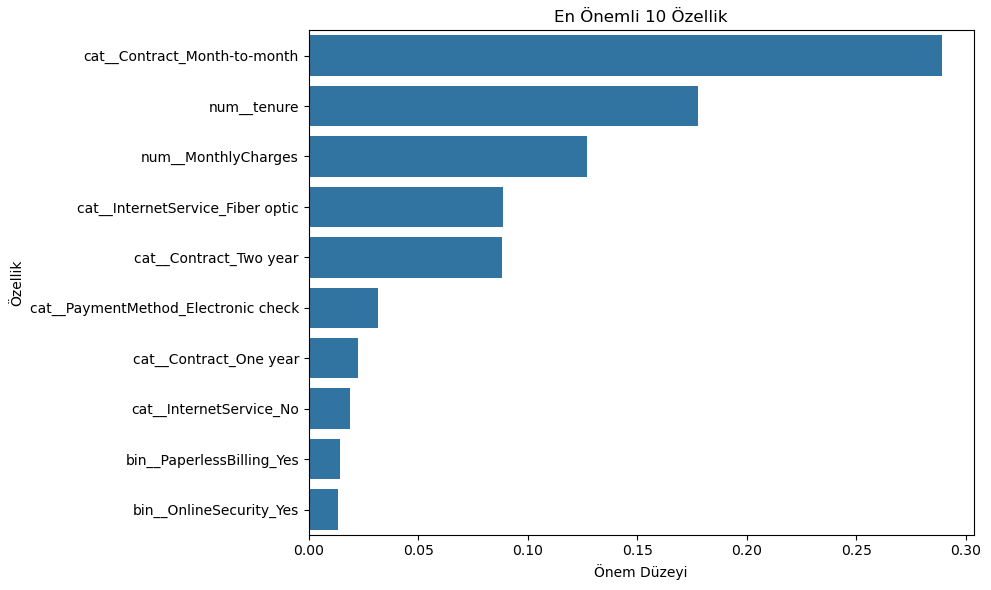

In [18]:
model_rf = best_model.named_steps["model"]
preprocess = best_model.named_steps["preprocessor"]

feature_names = preprocess.get_feature_names_out()
feature_importances = model_rf.feature_importances_
df_feature_importance = pd.DataFrame({"Özellik": feature_names,"Önem Skoru": feature_importances})

df_feature_importance = df_feature_importance.sort_values(by="Önem Skoru", ascending=False)
top_features = df_feature_importance.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features,x="Önem Skoru",y="Özellik")
plt.title("En Önemli 10 Özellik")
plt.xlabel("Önem Düzeyi")
plt.ylabel("Özellik")
plt.tight_layout()
plt.show()

In [19]:
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / pos

xgb = XGBClassifier(objective="binary:logistic",eval_metric="logloss",random_state=42,scale_pos_weight=scale_pos_weight)

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb)
])


param_grid_xgb = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__min_child_weight": [1, 5],
    "model__reg_lambda": [1, 10]
}


cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

grid_xgb = GridSearchCV(estimator=pipe_xgb,param_grid=param_grid_xgb,scoring="f1",cv=cv,n_jobs=-1,verbose=2)

grid_xgb.fit(X_train, y_train)

print("Best params:", grid_xgb.best_params_)

best_xgb = grid_xgb.best_estimator_

y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 300, 'model__reg_lambda': 10, 'model__subsample': 1.0}
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.52      0.80      0.63       372

    accuracy                           0.75      1405
   macro avg       0.72      0.77      0.72      1405
weighted avg       0.81      0.75      0.77      1405

[[763 270]
 [ 76 296]]
ROC-AUC: 0.8434926979566769


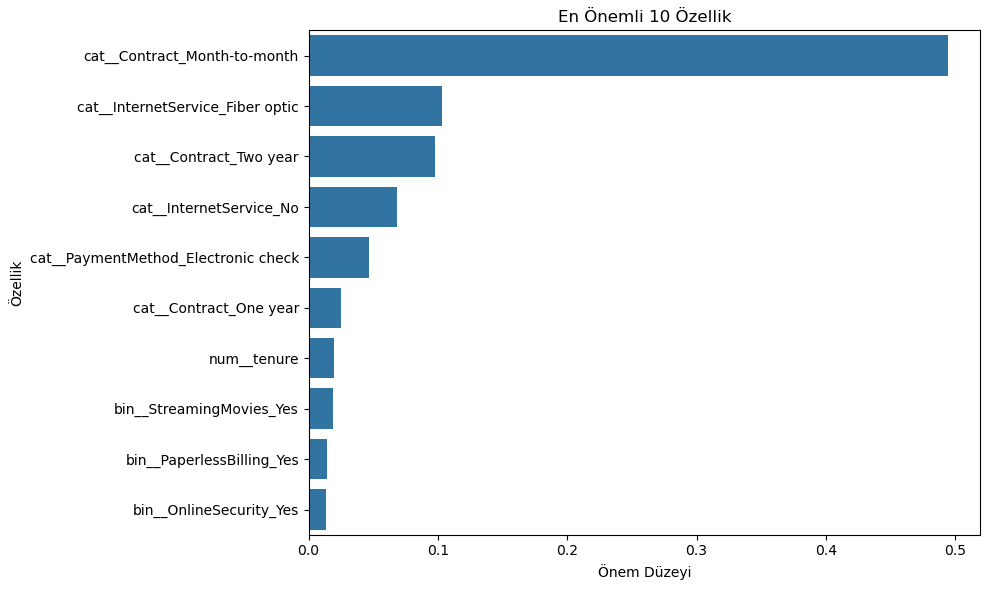

In [20]:
model_xgb = best_xgb.named_steps["model"]
preprocess = best_xgb.named_steps["preprocessor"]

feature_names = preprocess.get_feature_names_out()
feature_importances = model_xgb.feature_importances_
df_feature_importance = pd.DataFrame({"Özellik": feature_names,"Önem Skoru": feature_importances})

df_feature_importance = df_feature_importance.sort_values(by="Önem Skoru", ascending=False)
top_features = df_feature_importance.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features,x="Önem Skoru",y="Özellik")
plt.title("En Önemli 10 Özellik")
plt.xlabel("Önem Düzeyi")
plt.ylabel("Özellik")
plt.tight_layout()
plt.show()